In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
k = 1

In [150]:
from dyck_k_generator.generator import generate_dataset

generate_dataset(
    n=10_000,
    k=k,
    max_length=10,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 4000/4000 [00:00<00:00, 75801.82it/s]
Saving dataset to data/dyck-1_10000-samples_10-len_p06.jsonl: 100%|██████████| 10000/10000 [00:00<00:00, 628548.48it/s]

Dataset saved to data/dyck-1_10000-samples_10-len_p06.jsonl


In [151]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [152]:
from dataset.dataset import DyckLanguageDataset

In [153]:
dataset = DyckLanguageDataset("data/dyck-1_10000-samples_10-len_p06.jsonl", VOCAB).to(device)

Loaded 10000 samples from data/dyck-1_10000-samples_10-len_p06.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 706706.66it/s]


In [154]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [155]:
from torch.utils.data import DataLoader

In [156]:
dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [157]:
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Manual Transformer + BERTViz


In [158]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [161]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=128,
    n_heads=1,
    dim_ff=256,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [162]:
model = TransformerClassifier(model_config)

In [163]:
model.train()

TransformerClassifier(
  (embedding): Embedding(5, 128)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
        (ln1): La

In [164]:
model.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 128)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
        (ln1): La

In [165]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [166]:
from tqdm.auto import tqdm

In [168]:
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0

    total_correct = 0
    total_samples = 0

    for i, data in enumerate(tqdm(dl)):
        _, labels, tokens = data
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        tokens = tokens.to(device)

        optimizer.zero_grad()

        mask = pad_token_mask(tokens)

        outputs = model(tokens, mask=mask)

        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)

        # Count correct predictions
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Calculate accuracy
        accuracy = (total_correct / total_samples) * 100
        # calculate accuracy
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / 100}, Accuracy: {accuracy}%")
            running_loss = 0.0

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.0003413776948582381, Accuracy: 100.0%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.00018514813971705734, Accuracy: 100.0%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.00014131366639048794, Accuracy: 100.0%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.00011980673727521207, Accuracy: 100.0%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.00010578707995591686, Accuracy: 100.0%


In [169]:
model.eval()

TransformerClassifier(
  (embedding): Embedding(5, 128)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
        (ln1): La

In [170]:
correct = 0
total = 0
total_loss = 0

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():  # Important to use torch.no_grad() to save memory and computations
    for batch in tqdm(test_dl):
        _, labels, tokens = batch
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        tokens = tokens.to(device)

        mask = pad_token_mask(tokens)
        # Forward pass
        outputs = model(tokens, mask=mask)

        # Calculate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Convert outputs probabilities to predicted class (0 or 1)
        _, predicted = torch.max(outputs.data, 1)

        # Count total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_loss = total_loss / len(test_dl)
accuracy = 100 * correct / total

print(f"Accuracy of the model on the test data: {accuracy:.2f}%")
print(f"Average loss on the test data: {avg_loss:.4f}")

  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy of the model on the test data: 100.00%
Average loss on the test data: 0.0000


In [290]:
batch = next(iter(test_dl))
strings, labels, tokens = batch

mask = pad_token_mask(tokens)
attn_matrices = model.get_attn_matrices(tokens, mask)

In [291]:
print(strings[0], tokens[0], labels[0])

()()()()() tensor([0., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 2.], device='cuda:0') tensor(1., device='cuda:0')


In [292]:
attn_matrices[0].shape

torch.Size([8, 1, 12, 12])

In [293]:
attn_matrix = attn_matrices[0][0]
attn_matrix[0]

tensor([[0.0028, 0.0709, 0.1280, 0.0709, 0.1280, 0.0709, 0.1280, 0.0709, 0.1280,
         0.0709, 0.1280, 0.0027],
        [0.0435, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076,
         0.0724, 0.1076, 0.0565],
        [0.0708, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173,
         0.0497, 0.1173, 0.0944],
        [0.0435, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076,
         0.0724, 0.1076, 0.0565],
        [0.0708, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173,
         0.0497, 0.1173, 0.0944],
        [0.0435, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076,
         0.0724, 0.1076, 0.0565],
        [0.0708, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173,
         0.0497, 0.1173, 0.0944],
        [0.0435, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076, 0.0724, 0.1076,
         0.0724, 0.1076, 0.0565],
        [0.0708, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173, 0.0497, 0.1173,

In [294]:
from dataset.dataset import DyckLanguageTokenizer

In [295]:
tokenizer = DyckLanguageTokenizer(VOCAB)

In [296]:
labels = tokenizer.decode_single(tokens[0], remove_special_tokens=False).split(" ")
x_ticks = list(i for i in range(attn_matrices[0][0][0].shape[0]))
y_ticks = list(i for i in range(attn_matrices[0][0][0].shape[1]))

In [297]:
len(strings[0])

10

In [278]:
attn_matrices[0][0][0].shape

torch.Size([12, 12])

In [298]:
import numpy as np


def z_score_normalize(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix


def min_max_normalize(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

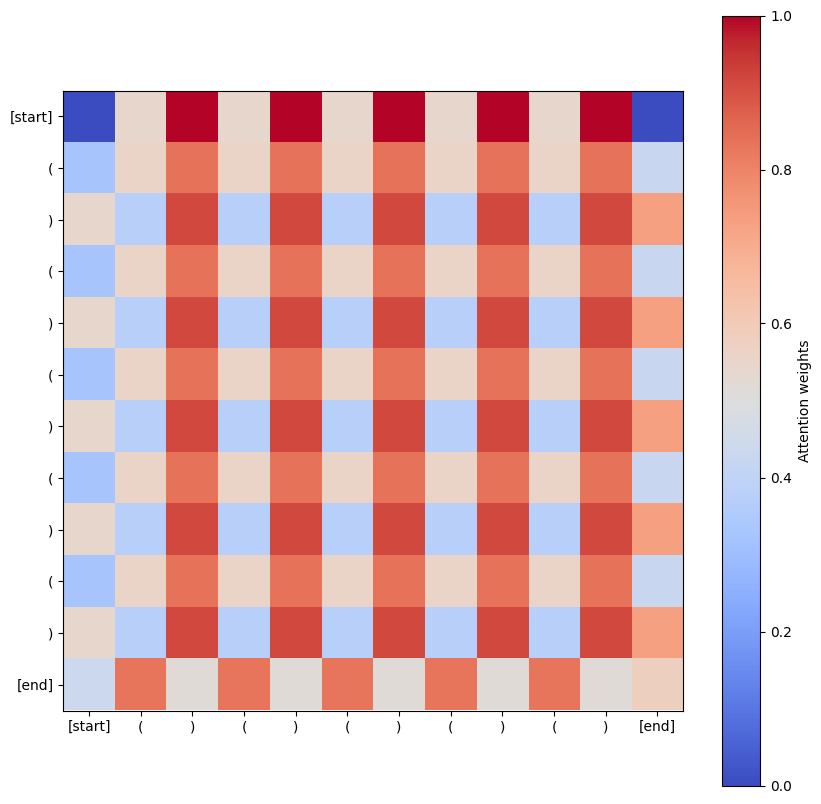

In [299]:
import matplotlib.pyplot as plt

# plot heatmap of first attention matrix
plt.figure(figsize=(10, 10))
heatmap = plt.imshow(
    min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy()),
    cmap="coolwarm",
    interpolation="nearest",
)

plt.xticks(ticks=x_ticks, labels=labels)
plt.yticks(ticks=y_ticks, labels=labels)
cbar = plt.colorbar(heatmap)
cbar.set_label("Attention weights")
plt.show()

In [300]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [302]:
minimax_norm[11][11]

0.5770061